In [ ]:
import pathlib
import numpy as np
import pandas as pd
import shapely
import warnings

warnings.filterwarnings("ignore")

# User Guide

This user guide will showcase the capabilities of *PedPy*. 
By following this guide you will learn how to set up your analysis and compute different metrics from the movement data.
This guide is designed as a [Jupyter notebook](https://jupyter.org/) where the individual cells can be executed in the given order, for trying it yourself you can copy the individual cells in a Python script and run it, or download the notebook {download}`here <./user_guide.ipynb>` it directly and run it locally.

If you use *PedPy* in your work, please cite it using the following information from zenodo:
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7386931.svg)](https://doi.org/10.5281/zenodo.7386931)

This is a bottleneck experiment conducted at the University of Wuppertal in 2018.
You can see the basic setup of the experiment in the picture below:

```{eval-rst}
.. figure:: demo-data/bottleneck/040_c_56_h-.png
    :width: 400px
    :align: center
```

The data for this experiment is available {download}`here <demo-data/bottleneck/040_c_56_h-.txt>`, which belongs to this [experimental series](https://doi.org/10.34735/ped.2018.1) and is part of the publication [\"Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology\"](https://doi.org/10.1098/rsif.2019.0871).

## Analysis set-up

The first step we will take, is to set up the analysis environment, this means define the areas where pedestrians can walk and put existing obstacles in it.
Also, we will define which areas are of interest for the later analysis.

### Walkable area

In the beginning we will define the {class}`walkable area <geometry.WalkableArea>` in which the pedestrian can move. 
For the used bottleneck experiment was conducted in the following set up:


```{eval-rst}
.. figure:: demo-data/bottleneck/experimental_setup.png
    :width: 50 %
    :align: center
```

The run handled in this user guide had a bottleneck width of 0.5m and w=5.6m.

Below is the code for creating such a {class}`walkable area <geometry.WalkableArea>`:

In [ ]:
from pedpy import WalkableArea

walkable_area = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier
        [
            (0.25, -1.1),
            (0.7, -1.1),
            (0.7, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.4, 0.0),
            (0.25, -0.15),
            (0.25, -1.1),
        ],
    ],
)

In [ ]:
from pedpy import plot_walkable_area
import matplotlib.pyplot as plt

plot_walkable_area(walkable_area=walkable_area).set_aspect("equal")
plt.show()

### Prepare measurement details

After we defined where the pedestrians can move, we now need to define in which regions we want to analyze in more details. 
This regions can either be a specific line, an area, or the whole {class}`walkable area <geometry.WalkableArea>`.

In case of this bottleneck the most interesting area is a little bit in front of the bottleneck (here 0.5m) and the line at the beginning of the bottleneck.
The area is slightly in front of the bottleneck as here the highest density occur. 
In *PedPy* such areas are called {class}`~geometry.MeasurementArea` and the lines {class}`~geometry.MeasurementLine`.
Below you can see how to define these:

In [ ]:
from pedpy import MeasurementArea, MeasurementLine

measurement_area = MeasurementArea(
    [(-0.4, 0.5), (0.4, 0.5), (0.4, 1.3), (-0.4, 1.3)]
)

measurement_line = MeasurementLine([(0.4, 0), (-0.4, 0)])

The corresponding measurement setup looks like:

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    walkable_area=walkable_area,
    measurement_lines=[measurement_line],
    ml_width=2,
    measurement_areas=[measurement_area],
    ma_line_width=2,
    ma_alpha=0.2,
).set_aspect("equal")
plt.show()

### Importing pedestrian movement data

The pedestrian movement data in *PedPy* is called {class}`trajectory data<trajectory_data.TrajectoryData>`.

*PedPy* works with {class}`trajectory data<trajectory_data.TrajectoryData>` which can be created from an import function for specific data files alternatively from a {class}`~pandas.DataFrame` with the following columns:

- "id": unique numeric identifier for each person
- "frame": index of video frame where the positions were extracted
- "x", "y": position of the person (in meter) 

#### Loading from Pandas DataFrame

To construct the  {class}`trajectory data<trajectory_data.TrajectoryData>` from a {class}`~pandas.DataFrame` you also need to provide the frame rate at which the data was recorded.
If you have both the construction of the {class}`trajectory data<trajectory_data.TrajectoryData>` can be done with:

In [ ]:
from pedpy import TrajectoryData

data = pd.DataFrame(
    [[0, 1, 0, 0]],
    columns=["id", "frame", "x", "y"],
)
trajectory_data = TrajectoryData(data=data, frame_rate=25.0)

Alternatively, the data can be also loaded from any file format that is supported by *Pandas*, see the [documentation](https://pandas.pydata.org/pandas-docs/version/2.0/user_guide/io.html) for more details.


#### Loading from text trajectory files

*Pedpy* can load trajectories, if they are stored as the {class}`trajectory data<trajectory_data.TrajectoryData>` provided in the [Jülich Data Archive](https://ped.fz-juelich.de/da/doku.php) directly.
If you have text files in same format, you can load them in the same way too:

- values are separated by any whitespace, e.g., space, tab
- file has at least 4 columns in the following order: "id", "frame", "x", "y"
- file may contain comment lines with `#` at in the beginning

For meaningful analysis (and loading of the trajectory file) you also need
- unit of the trajectory (m or cm)
- frame rate

For recent trajectory they are encoded in the header of the file, for older you may need to lead the documentation and provide the information in the loading process.

**Examples:**
With frame rate, but no unit
```
# description: UNI_CORR_500_01
# framerate: 25.00
#geometry: geometry.xml

# PersID	Frame	X	Y	Z
1	98	4.6012	1.8909	1.7600
1	99	4.5359	1.8976	1.7600
1	100	4.4470	1.9304	1.7600
...
```

No header at all:
```
1 27 164.834 780.844 168.937
1 28 164.835 771.893 168.937
1 29 163.736 762.665 168.937
1 30 161.967 753.088 168.937
...
```

If your data is structured in a different way please take a look at the next section.
Since the data we want to analyze is from the data archive, we can directly load the {class}`trajectory data<trajectory_data.TrajectoryData>` with *PedPy*:  

In [ ]:
from pedpy import load_trajectory, TrajectoryUnit

traj = load_trajectory(
    trajectory_file=pathlib.Path("demo-data/bottleneck/040_c_56_h-.txt"),
    default_unit=TrajectoryUnit.METER,  # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

The loaded {class}`trajectory data<trajectory_data.TrajectoryData>` look like:

In [ ]:
from pedpy import plot_trajectories
import matplotlib.pyplot as plt

plot_trajectories(traj=traj).set_aspect("equal")
plt.show()

#### Loading from hdf5 trajectory files

For some experiments the [Jülich Data Archive](https://ped.fz-juelich.de/da/doku.php) also provides [HDF5](https://www.hdfgroup.org/HDF5) trajectory files, with a structure described [here](https://ped.fz-juelich.de/da/doku.php?id=info).
These data are from a different experiment, and are only used to demonstrate how to load HDF5 files, it can be downloaded {download}`here <demo-data/single_file/00_01a.h5>`.

To make the data usable for *PedPy* use:

In [ ]:
from pedpy import (
    TrajectoryData,
    load_trajectory_from_ped_data_archive_hdf5,
    load_walkable_area_from_ped_data_archive_hdf5,
)
import pathlib

h5_file = pathlib.Path("demo-data/single_file/00_01a.h5")

traj_h5 = load_trajectory_from_ped_data_archive_hdf5(trajectory_file=h5_file)
walkable_area_h5 = load_walkable_area_from_ped_data_archive_hdf5(
    trajectory_file=h5_file
)

In [ ]:
import matplotlib.pyplot as plt
from pedpy import plot_trajectories

plot_trajectories(traj=traj_h5, walkable_area=walkable_area_h5).set_aspect(
    "equal"
)
plt.show()

#### Loading from Viswalk trajectory files

It is also possible to load trajectory files from [Viswalk](https://www.ptvgroup.com/en/products/pedestrian-simulation-software-ptv-viswalk) directly into *PedPy*. 
The expected format is a CSV file with `;` as delimiter, and it should contain at least the following columns: `NO`, `SIMSEC`, `COORDCENTX`, `COORDCENTY`.
Comment lines may start with a `*` and will be ignored.

:::{important}
Currently only Viswalk trajectory files, which use the simulation time (`SIMSEC`) are supported.
:::


To make the data usable for *PedPy* use:

In [ ]:
from pedpy import (
    TrajectoryData,
    load_trajectory_from_viswalk,
)
import pathlib

viswalk_file = pathlib.Path("demo-data/viswalk/example.pp")

traj_viswalk = load_trajectory_from_viswalk(trajectory_file=viswalk_file)

In [ ]:
import matplotlib.pyplot as plt
from pedpy import plot_trajectories

plot_trajectories(traj=traj_viswalk).set_aspect("equal")
plt.show()

### Plot setup

For a better overview of our created measurement setup, see the plot below:

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area,
    measurement_areas=[measurement_area],
    measurement_lines=[
        measurement_line,
    ],
    traj_alpha=0.7,
    traj_width=0.4,
    ml_width=2,
    ma_alpha=0.2,
    ma_line_width=2,
).set_aspect("equal")
plt.show()

### Validate that trajectory is completely inside the walkable area.

An important step before starting the analysis is to verify that all trajectories lie within the constructed {class}`walkable area <geometry.WalkableArea>`.
Otherwise, you might get errors.
*PedPy* provides a function to test your trajectories, and offers also a function to get all invalid trajectories:

In [ ]:
from pedpy import is_trajectory_valid, get_invalid_trajectory

print(
    f"Trajectory is valid: {is_trajectory_valid(traj_data=traj, walkable_area=walkable_area)}"
)
get_invalid_trajectory(traj_data=traj, walkable_area=walkable_area)

**For demonstration purposes, wrongly place the obstacle s.th. some pedestrian walk through it!**

We now create a faulty geometry, s.th. you can see how the result would like.
Therefore, the right obstacle will be moved a bit towards the center of the bottlneck:

In [ ]:
from pedpy import WalkableArea

walkable_area_faulty = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier is too close to the middle
        [
            (0.15, -1.1),
            (0.6, -1.1),
            (0.6, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.3, 0.0),
            (0.15, -0.15),
            (0.15, -1.1),
        ],
    ],
)

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

ax = plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area_faulty,
    traj_alpha=0.5,
    traj_width=1,
    hole_color="lightgrey",
)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
plt.show()

If you get any invalid trajectories, you should check whether you constructed your {class}`walkable area <geometry.WalkableArea>` correctly.
In some cases you will get such errors when you have head trajectories, and the pedestrian lean over the obstacles.
Then you need to prepare your data before you can start your analysis.

In [ ]:
from pedpy import is_trajectory_valid, get_invalid_trajectory

print(
    f"Trajectory is valid: {is_trajectory_valid(traj_data=traj, walkable_area=walkable_area_faulty)}"
)
get_invalid_trajectory(traj_data=traj, walkable_area=walkable_area_faulty)

## Analysis

Now that we set up the analysis environment, we can start with the real analysis.
*PedPy* provides different methods to obtain multiple metric from the {class}`trajectory data<trajectory_data.TrajectoryData>`:

- Density
- Speed
- Flow
- Neighborhood
- Distance/Time to entrance
- Profiles

### Density

Density is a fundamental metric in pedestrian dynamics.
As it indicated how much space is accessible to each pedestrian within a specific area.
High density can lead to reduced walking speeds, increased congestion, and even potential safety hazards.

#### Classic density

The classic approach to calculate the density $\rho_{classic}(t)$ at a time $t$, is to count the number of pedestrians ($N(t)$) inside a specific space ($M$) and divide it by the area of that space ($A(M)$).

$$
\rho_{classic}(t) = {N(t) \over A(M)}
$$

In *PedPy* this can be computed with:


In [ ]:
from pedpy import compute_classic_density

classic_density = compute_classic_density(
    traj_data=traj, measurement_area=measurement_area
)

The resulting time-series can be seen below:

In [ ]:
from pedpy import plot_density
import matplotlib.pyplot as plt

plot_density(density=classic_density, title="Classic density")
plt.show()

(voronoi_density)=
 #### Voronoi density

Another approach for calculating the density is to compute the [Voronoi tesselation](https://en.wikipedia.org/wiki/Voronoi_diagram) of the pedestrians positions at a given time $t$, the resulting Voronoi polygons ($V$) directly relate to the individual's density.
For a pedestrian $i$ the individual density is defined as:

$$
\rho_i(t) = {1 \over A(V_i(t)}
$$


##### Compute individual Voronoi Polygons

The first step for computing the Voronoi density, is to compute the individual's Voronoi polygon.
As these polygons may become infinite for pedestrians at the edge of the crowd, these polygons are restricted by the {class}`walkable area <geometry.WalkableArea>`.
This cutting at the boundaries can lead to split Voronoi polygons. For each of the split polygons it is checked, in which the pedestrian is located. 
This polygon then is assigned.

:::{important}
As these Voronoi polygons work on the Euclidean distance, some unexpected artifacts may occur on non-convex {class}`walkable areas <geometry.WalkableArea>`. Please keep that in mind! How that may look like, you can see in the plots later in this guide.
:::

###### Without cut-off

The computation of the individual polygons can be done from the {class}`trajectory data<trajectory_data.TrajectoryData>` and {class}`walkable area <geometry.WalkableArea>` with:

In [ ]:
from pedpy import compute_individual_voronoi_polygons

individual = compute_individual_voronoi_polygons(
    traj_data=traj, walkable_area=walkable_area
)

###### With cut-off

When having a large {class}`walkable area <geometry.WalkableArea>` or widely spread pedestrians the Voronoi polygons may become quite large.
In *PedPy* it is possible to restrict the size of the computed Polygons.
This can be done by defining a {class}`cut off <method_utils.CutOff>`, which is essentially an approximated circle which gives the maximum extension of a single Voronoi polygon.
For the creation of the {class}`cut off <method_utils.CutOff>`, we need to define how accurate we want to approximate the circle, the differences can be seen below:

```{eval-rst}
.. figure:: images/voronoi_cutoff_differences.svg
    :align: center
```

Now, with that {class}`cut off <method_utils.CutOff>` the computation of the individual polygons becomes:

In [ ]:
from pedpy import compute_individual_voronoi_polygons, Cutoff

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=1.0, quad_segments=3),
)

###### Comparison

To get a better impression what the differences between the Voronoi polygons with and without the {class}`cut off <method_utils.CutOff>` are, take a look at the plot below:

In [ ]:
from pedpy.column_identifier import ID_COL, FRAME_COL, DENSITY_COL
from pedpy import plot_voronoi_cells
import matplotlib as mpl
import matplotlib.pyplot as plt

frame = 600

fig = plt.figure(f"frame = {frame}")
fig.suptitle(f"frame = {frame}")

ax1 = fig.add_subplot(121, aspect="equal")
ax1.set_title("w/o cutoff")
plot_voronoi_cells(
    voronoi_data=individual,
    traj_data=traj,
    frame=frame,
    walkable_area=walkable_area,
    color_by_column=DENSITY_COL,
    axes=ax1,
    show_colorbar=False,
    vmin=0,
    vmax=10,
)

ax2 = fig.add_subplot(122, aspect="equal")
ax2.set_title("w cutoff")

plot_voronoi_cells(
    voronoi_data=individual_cutoff,
    traj_data=traj,
    frame=frame,
    walkable_area=walkable_area,
    color_by_column=DENSITY_COL,
    axes=ax2,
    show_colorbar=False,
    vmin=0,
    vmax=10,
)
cbar_ax = fig.add_axes([0.1, -0.05, 0.88, 0.05])

norm = mpl.colors.Normalize(vmin=0, vmax=10)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("YlGn"), norm=norm)
sm.set_array([])
plt.colorbar(
    sm,
    cax=cbar_ax,
    shrink=0.1,
    label="$\\rho$ \ 1/$m^2$",
    aspect=2,
    orientation="horizontal",
)

fig.tight_layout()
plt.show()

##### Compute actual Voronoi density

From these individual data we can now compute the Voronoi density $\rho_{voronoi}(t)$ in the known {class}`measurement area <geometry.MeasurementArea>` ($M$):

$$
    \rho_{voronoi}(t) = { \int\int \rho_{xy}(t) dxdy \over A(M)},
$$

where $\rho_{xy}(t) = 1 / A(V_i(t))$ is the individual density of each pedestrian, whose $V_i(t) \cap M$ and $A(M)$ the area of the {class}`measurement area <geometry.MeasurementArea>`.

###### Without cut-off

First, we compute the Voronoi density in the {class}`measurement area <geometry.MeasurementArea>` without a {class}`cut off <method_utils.CutOff>`:

In [ ]:
from pedpy import compute_voronoi_density

density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual, measurement_area=measurement_area
)

In [ ]:
from pedpy import plot_density, PEDPY_ORANGE
import matplotlib.pyplot as plt

plot_density(
    density=density_voronoi, title="Voronoi density", color=PEDPY_ORANGE
)
plt.show()

###### With cut-off

Second, we compute it now from the individual {class}`cut off <method_utils.CutOff>` Voronoi polygons:


In [ ]:
from pedpy import compute_voronoi_density

density_voronoi_cutoff, intersecting_cutoff = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=measurement_area
)

In [ ]:
from pedpy import plot_density, PEDPY_GREY
import matplotlib.pyplot as plt

plot_density(
    density=density_voronoi_cutoff,
    title="Voronoi density with cut-off",
    color=PEDPY_GREY,
)
plt.show()

#### Comparison

Now we have obtained the mean density inside the {class}`measurement area <geometry.MeasurementArea>` with different methods.
To compare the results take a look at the following plot:

In [ ]:
from pedpy import PEDPY_BLUE, PEDPY_ORANGE, PEDPY_GREY
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title("Comparison of different density methods")
plt.plot(
    classic_density.reset_index().frame,
    classic_density.values,
    label="classic",
    color=PEDPY_BLUE,
)
plt.plot(
    density_voronoi.reset_index().frame,
    density_voronoi,
    label="voronoi",
    color=PEDPY_ORANGE,
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff,
    label="voronoi with cutoff",
    color=PEDPY_GREY,
)
plt.xlabel("frame")
plt.ylabel("$\\rho$ / 1/$m^2$")
plt.grid()
plt.legend()
plt.show()

(passing_density)=
 #### Passing density (individual)

Another option to compute the individual density, is the passing density. 
For the computation it needs a {class}`measurement line <geometry.MeasurementLine>` and the distance to a second "virtual" {class}`measurement line <geometry.MeasurementLine>` which form a "virtual" {class}`measurement area <geometry.MeasurementArea>` ($M$).

```{eval-rst}
.. image:: /images/passing_area_from_lines.svg
    :width: 80 %
    :align: center
```

For each pedestrians now the frames when they enter and leave the virtual {class}`measurement area <geometry.MeasurementArea>` is computed. 
In this frame interval they have to be inside the {class}`measurement area <geometry.MeasurementArea>` continuously. 
They also need to enter and leave the {class}`measurement area <geometry.MeasurementArea>` via different {class}`measurement lines <geometry.MeasurementLine>`.
If leaving the area between the two lines, crossing the same line twice they will be ignored. 
For a better understanding, see the image below, where red parts of the trajectories are the detected ones inside the area. 
These frame intervals will be returned.

```{eval-rst}
.. image:: /images/frames_in_area.svg
    :width: 80 %
    :align: center
```

In this our example, we want to measure from the entrance of the bottleneck (top line) 1m towards the exit of the bottleneck (bottom line).
The set-up is shown below:

In [ ]:
from pedpy import compute_frame_range_in_area

frames_in_area, used_area = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=1.0
)

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    measurement_areas=[used_area],
    measurement_lines=[
        measurement_line,
        MeasurementLine(shapely.offset_curve(measurement_line.line, 1.0)),
    ],
    ml_width=2,
    ma_line_width=0,
    ma_alpha=0.2,
    walkable_area=walkable_area,
).set_aspect("equal")
plt.show()

The passing density for each pedestrian $\rho_{passing}(i)$ is the average number of pedestrian who are in the same {class}`measurement area <geometry.MeasurementArea>` $M$ in the same time interval ($[t_{in}(i), t_{out}(i)]$) as pedestrian $i$, divided by the area of that {class}`measurement area <geometry.MeasurementArea>` $A(M)$.

Then the computation becomes:

$$
    \rho_{passing}(i) = {1 \over {t_{out}(i)-t_{in}(i)}}
    \int^{t_{out}(i)}_{t_{in}(i)} {{N(t)} \over A(M)} dt
$$

where $t_{in}(i) = f_{in}(i) / fps$ is the time the pedestrian crossed the first line and $t_{out}(i) = f_{out}(i) / fps$ when they crossed the second line, where $f_{in}$ and $f_{out}$ are the frames where the pedestrian crossed the first line, and the second line respectively. 
And $fps$ is the frame rate of the {class}`trajectory data<trajectory_data.TrajectoryData>`.

Here, we want to compute the passing density inside the bottleneck, this can be done with:


In [ ]:
from pedpy import compute_passing_density
from pedpy import compute_frame_range_in_area

frames_in_area, used_area = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=1.0
)
passing_density = compute_passing_density(
    density_per_frame=classic_density, frames=frames_in_area
)

This gives for each pedestrian one value for the density. 
The following plot shows how the individual density inside is distributed the bottleneck:

In [ ]:
from pedpy import plot_density_distribution
import matplotlib.pyplot as plt

plot_density_distribution(
    density=passing_density, title="Individual density inside bottleneck"
)
plt.show()

### Speed

A further important measure in pedestrian dynamics is the speed of the pedestrians.
Low speeds can indicate congestions or other obstructions in the flow of the crowd.

#### Individual speed

For computing the individuals speed at a specific frame $v_i(t)$, a specific frame step ($n$) is needed.
Together with the frame rate of the {class}`trajectory data<trajectory_data.TrajectoryData>` $fps$ the time frame $\Delta t$ for computing the speed becomes:

$$
    \Delta t = 2 n / fps
$$

This time step describes how many frames before and after the current position $X_{current}$ are used to compute the movement.
These positions are called $X_{future}$, $X_{past}$, respectively.

```{eval-rst}
.. image:: /images/speed_both.svg
    :width: 80 %
    :align: center
```

First computing the displacement between these positions $\bar{X}$.
This then can be used to compute the speed with:

$$\begin{align}
    \bar{X} &= X_{future} - X_{past} \\
    v_i(t) &= \frac{\bar{X}}{\Delta t}
\end{align}$$

When getting closer to the start, or end of the {class}`trajectory data<trajectory_data.TrajectoryData>`, it is not possible to use the full range of the frame interval for computing the speed.
For these cases *PedPy* offers three different methods to compute the speed:

1. exclude these parts
2. adaptively shrink the window in which the speed is computed
3. switch to one-sided window

##### Exclude border

When not enough frames available to compute the speed at the borders, for these parts no speed can be computed and they are ignored.


In [ ]:
from pedpy import compute_individual_speed, SpeedCalculation

frame_step = 25

individual_speed_exclude = compute_individual_speed(
    traj_data=traj,
    frame_step=frame_step,
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_EXCLUDE,
)

In [ ]:
from pedpy import PEDPY_GREEN
import matplotlib.pyplot as plt

ped_id = 25

plt.figure()
plt.title(f"Speed time-series of a pedestrian {ped_id} (border excluded)")
single_individual_speed = individual_speed_exclude[
    individual_speed_exclude.id == ped_id
]
plt.plot(
    single_individual_speed.frame,
    single_individual_speed.speed,
    color=PEDPY_GREEN,
)

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

##### Adaptive border window

In the adaptive approach, it is checked how many frames $n$ are available to from $X_{current}$ to the end of the trajectory.
This number is then used on both sides to create a smaller symmetric window, which yields $X_{past}$ and $X_{future}$.
Now with the same principles as before the individual speed $v_i(t)$ can be computed.

```{eval-rst}
.. image:: images/speed_border_adaptive_future.svg
    :width: 46 %
.. image:: images/speed_border_adaptive_past.svg
    :width: 46 %
```

:::{important}
As the time interval gets smaller to the ends of the individual trajectories, the oscillations in the speed increase here.
:::


In [ ]:
from pedpy import compute_individual_speed, SpeedCalculation

individual_speed_adaptive = compute_individual_speed(
    traj_data=traj,
    frame_step=frame_step,
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_ADAPTIVE,
)

In [ ]:
from pedpy import PEDPY_RED
import matplotlib.pyplot as plt

plt.figure()
plt.title(f"Speed time-series of an pedestrian {ped_id} (adaptive)")
single_individual_speed = individual_speed_adaptive[
    individual_speed_adaptive.id == ped_id
]
plt.plot(
    single_individual_speed.frame,
    single_individual_speed.speed,
    color=PEDPY_RED,
)

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

##### Single sided border window

In these cases, one of the end points to compute the movement becomes the current position $X_{current}$.
When getting too close to the start of the trajectory, the movement is computed from $X_{current}$ to $X_{future}$.
In the other case the movement is from $X_{past}$ to $X_{current}$.

$$
    v_i(t) = {|{X_{future} - X_{current}|}\over{ \frac{1}{2} \Delta t}} \text{, or } v_i(t) = {|{X_{current} - X_{past}|}\over{ \frac{1}{2} \Delta t}}
$$

```{eval-rst}
.. image:: images/speed_border_single_sided_future.svg
    :width: 46 %
.. image:: images/speed_border_single_sided_past.svg
    :width: 46 %
```

:::{important}
As at the edges of the trajectories the time interval gets halved, there may occur some jumps computed speeds at this point.
:::

In [ ]:
from pedpy import compute_individual_speed, SpeedCalculation

individual_speed_single_sided = compute_individual_speed(
    traj_data=traj,
    frame_step=frame_step,
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
)

In [ ]:
from pedpy import PEDPY_GREY
import matplotlib.pyplot as plt

plt.figure()
plt.title(f"Speed time-series of an pedestrian {ped_id} (single sided)")
single_individual_speed = individual_speed_single_sided[
    individual_speed_single_sided.id == ped_id
]
plt.plot(
    single_individual_speed.frame,
    single_individual_speed.speed,
    color=PEDPY_GREY,
)

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

##### Comparison

To demonstrate the differences in the computed speeds, take a look at the following plot:


In [ ]:
from pedpy import PEDPY_GREY, PEDPY_RED, PEDPY_GREEN
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    1, 3, gridspec_kw={"width_ratios": [2, 1, 1]}, sharey=True, figsize=(12, 5)
)

fig.suptitle("Comparison of the different speed calculations at the borders")
speed_exclude = individual_speed_exclude[individual_speed_exclude.id == ped_id]
speed_adaptive = individual_speed_adaptive[
    individual_speed_adaptive.id == ped_id
]
speed_single_sided = individual_speed_single_sided[
    individual_speed_single_sided.id == ped_id
]

ax[0].plot(
    speed_single_sided.frame,
    speed_single_sided.speed,
    color=PEDPY_GREY,
    linewidth=3,
    label="single sided",
)
ax[0].plot(
    speed_adaptive.frame,
    speed_adaptive.speed,
    color=PEDPY_RED,
    linewidth=3,
    label="adaptive",
)
ax[0].plot(
    speed_exclude.frame,
    speed_exclude.speed,
    color=PEDPY_GREEN,
    linewidth=3,
    label="excluded",
)
ax[0].set_xlabel("frame")
ax[0].set_ylabel("v / m/s")
ax[0].legend()

ax[1].plot(
    speed_single_sided.frame[
        speed_single_sided.frame
        < speed_single_sided.frame.min() + 3 * frame_step
    ],
    speed_single_sided.speed[
        speed_single_sided.frame
        < speed_single_sided.frame.min() + 3 * frame_step
    ],
    color=PEDPY_GREY,
    linewidth=3,
)
ax[1].plot(
    speed_adaptive.frame[
        speed_adaptive.frame < speed_single_sided.frame.min() + 3 * frame_step
    ],
    speed_adaptive.speed[
        speed_adaptive.frame < speed_single_sided.frame.min() + 3 * frame_step
    ],
    color=PEDPY_RED,
    linewidth=3,
)
ax[1].plot(
    speed_exclude.frame[
        speed_exclude.frame < speed_single_sided.frame.min() + 3 * frame_step
    ],
    speed_exclude.speed[
        speed_exclude.frame < speed_single_sided.frame.min() + 3 * frame_step
    ],
    color=PEDPY_GREEN,
    linewidth=3,
)
ax[1].set_xlabel("frame")

ax[2].plot(
    speed_single_sided.frame[
        speed_single_sided.frame
        > speed_single_sided.frame.max() - 3 * frame_step
    ],
    speed_single_sided.speed[
        speed_single_sided.frame
        > speed_single_sided.frame.max() - 3 * frame_step
    ],
    color=PEDPY_GREY,
    linewidth=3,
)
ax[2].plot(
    speed_adaptive.frame[
        speed_adaptive.frame > speed_single_sided.frame.max() - 3 * frame_step
    ],
    speed_adaptive.speed[
        speed_adaptive.frame > speed_single_sided.frame.max() - 3 * frame_step
    ],
    color=PEDPY_RED,
    linewidth=3,
)
ax[2].plot(
    speed_exclude.frame[
        speed_exclude.frame > speed_single_sided.frame.max() - 3 * frame_step
    ],
    speed_exclude.speed[
        speed_exclude.frame > speed_single_sided.frame.max() - 3 * frame_step
    ],
    color=PEDPY_GREEN,
    linewidth=3,
)

ax[2].set_xlabel("frame")
plt.show()

##### Individual speed in specific movement direction

It is also possible to compute the individual speed in a specific direction $d$, for this the movement $\bar{X}$ is projected onto the desired movement direction. $\bar{X}$ and $\Delta t$ are computed as described above. 
Hence, the speed then becomes:

$$
    v_i(t) = {{|\boldsymbol{proj}_d\; \bar{X}|} \over {\Delta t}}
$$

```{eval-rst}
.. image:: images/speed_movement_direction.svg
    :width: 80 %
```

:::{important}
When using a specific direction, the computed speed may become negative.
:::

In [ ]:
individual_speed_direction = compute_individual_speed(
    traj_data=traj,
    frame_step=5,
    movement_direction=np.array([0, -1]),
    compute_velocity=True,
    speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
)

In [ ]:
from pedpy import PEDPY_BLUE, PEDPY_GREY, PEDPY_RED, PEDPY_GREEN
import matplotlib.pyplot as plt

colors = [PEDPY_BLUE, PEDPY_GREY, PEDPY_RED, PEDPY_GREEN]
ped_ids = [10, 20, 17, 70]

fig = plt.figure()
plt.title(
    "Velocity time-series of an excerpt of the pedestrians in a specific direction"
)
for color, ped_id in zip(colors, ped_ids):
    single_individual_speed = individual_speed_direction[
        individual_speed_direction.id == ped_id
    ]
    plt.plot(
        single_individual_speed.frame,
        single_individual_speed.speed,
        color=color,
    )

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

(mean_speed)=
 #### Mean speed

Now, that we have computed the individual's speed, we want to compute the mean speed in the already used {class}`measurement area <geometry.MeasurementArea>` $M$ closely in front of the bottleneck.
The mean speed is defined as

$$
    v_{mean}(t) = {{1} \over {N}} \sum_{i \in P_M} v_i(t), 
$$

where $P_M$ are all pedestrians inside the {class}`measurement area <geometry.MeasurementArea>`, and $N$ the number of pedestrians inside the {class}`measurement area <geometry.MeasurementArea>` ($|P_M|$).

:::{important}
The mean speed can only be computed when for each pedestrian inside the {class}`measurement area <geometry.MeasurementArea>` also a speed $v_i(t)$ is computed, when using the exclude or adaptive approach this might not be the case.
Then some extra processing steps are needed, to avoid this use the single sided approach. 
:::

This can be as follows with *PedPy*:
 

In [ ]:
from pedpy import compute_mean_speed_per_frame

mean_speed = compute_mean_speed_per_frame(
    traj_data=traj,
    measurement_area=measurement_area,
    individual_speed=individual_speed_single_sided,
)

In [ ]:
from pedpy import plot_speed, PEDPY_BLUE
import matplotlib.pyplot as plt

plot_speed(
    speed=mean_speed,
    title="Mean speed in front of the bottleneck",
    color=PEDPY_BLUE,
)
plt.show()

The same can be now computed, using the speed in a movement direction as basis:

In [ ]:
mean_speed_direction = compute_mean_speed_per_frame(
    traj_data=traj,
    measurement_area=measurement_area,
    individual_speed=individual_speed_direction,
)

In [ ]:
from pedpy import plot_speed, PEDPY_RED
import matplotlib.pyplot as plt

plot_speed(
    speed=mean_speed_direction,
    title="Mean speed in specific direction in front of the bottleneck",
    color=PEDPY_RED,
)
plt.show()

(voronoi_speed)=
 #### Voronoi speed

A further approach to compute average speed $v_{voronoi}(t)$ in an area by weighting the individuals speed by the size of their corresponding Voronoi polygon $V_i$ inside the {class}`measurement area <geometry.MeasurementArea>` $M$.
The individuals speed are weighted by the proportion of their Voronoi cell $V_i$ and the intersection with the {class}`measurement area <geometry.MeasurementArea>` $V_i \cap M$.

The Voronoi speed $v_{voronoi}(t)$ is defined as

$$
        v_{voronoi}(t) = { \int\int v_{xy}(t) dxdy \over A(M)},
$$

where $v_{xy}(t) = v_i(t)$ is the individual speed of each pedestrian, whose $V_i(t) \cap M$ and $A(M)$ the area of the {class}`measurement area <geometry.MeasurementArea>`.

```{eval-rst}
.. image:: /images/voronoi_density.svg
    :width: 60 %
    :align: center
```

:::{important}
The Voronoi speed can only be computed when for each pedestrian inside the {class}`measurement area <geometry.MeasurementArea>` also a speed $v_i(t)$ is computed, when using the exclude or adaptive approach this might not be the case.
Then some extra processing steps are needed, to avoid this use the single sided approach. 
:::

This can be done in *PedPy* with:

In [ ]:
from pedpy import compute_voronoi_speed

voronoi_speed = compute_voronoi_speed(
    traj_data=traj,
    individual_voronoi_intersection=intersecting,
    individual_speed=individual_speed_single_sided,
    measurement_area=measurement_area,
)

In [ ]:
from pedpy import plot_speed, PEDPY_ORANGE
import matplotlib.pyplot as plt

plot_speed(
    speed=voronoi_speed,
    title="Voronoi speed in front of the bottleneck",
    color=PEDPY_ORANGE,
)
plt.show()

Analogously, this can be done with the speed in a specific direction with:

In [ ]:
voronoi_speed_direction = compute_voronoi_speed(
    traj_data=traj,
    individual_voronoi_intersection=intersecting,
    individual_speed=individual_speed_direction,
    measurement_area=measurement_area,
)

In [ ]:
from pedpy import plot_speed, PEDPY_GREY
import matplotlib.pyplot as plt

plot_speed(
    speed=voronoi_speed,
    title="Voronoi velocity in specific direction in front of the bottleneck",
    color=PEDPY_GREY,
)
plt.show()

#### Comparison mean speed vs Voronoi speed

We now computed the speed with different methods, this plot shows what the different results look like compared to each other:

In [ ]:
from pedpy import PEDPY_ORANGE, PEDPY_GREY, PEDPY_BLUE, PEDPY_RED
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Comparison of different speed methods")
plt.plot(
    voronoi_speed.reset_index().frame,
    voronoi_speed,
    label="Voronoi",
    color=PEDPY_ORANGE,
)
plt.plot(
    voronoi_speed_direction.reset_index().frame,
    voronoi_speed_direction,
    label="Voronoi direction",
    color=PEDPY_GREY,
)
plt.plot(
    mean_speed.reset_index().frame,
    mean_speed,
    label="classic",
    color=PEDPY_BLUE,
)
plt.plot(
    mean_speed_direction.reset_index().frame,
    mean_speed_direction,
    label="classic direction",
    color=PEDPY_RED,
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

#### Passing speed (individual)

With the same principles as described in [passing density](passing_density), the individual speeds $v^i_{passing}$ is defined as

$$
    v^i_{passing} = \frac{d}{t_{out}-t_{in}},
$$

where $d$ is the distance between the two {class}`measurement lines <geometry.MeasurementLine>`.

In *PedPy* this can be done with: 

In [ ]:
from pedpy import compute_passing_speed
from pedpy import compute_frame_range_in_area

passing_offset = 1.0
frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=passing_offset
)
passing_speed = compute_passing_speed(
    frames_in_area=frames_in_area,
    frame_rate=traj.frame_rate,
    distance=passing_offset,
)

In [ ]:
from pedpy import plot_speed_distribution
import matplotlib.pyplot as plt

plot_speed_distribution(
    speed=passing_speed, title="Individual speed in bottleneck"
)
plt.show()

### Flow

Another important metric, when analyzing pedestrian flows is the flow itself.
It describes how many persons cross a line in a given time.
From this potential bottlenecks or congestion can be derived.

#### N-t diagram at bottleneck

To get a first impression of the flow at the bottleneck we look at the N-t diagram, which shows how many pedestrian have crossed the {class}`measurement line <geometry.MeasurementLine>` at a specific time.

In [ ]:
from pedpy import compute_n_t

nt, crossing = compute_n_t(
    traj_data=traj,
    measurement_line=measurement_line,
)

In [ ]:
from pedpy import plot_nt
import matplotlib.pyplot as plt

plot_nt(nt=nt, title="N-t at bottleneck")
plt.show()

#### Flow at bottleneck

From the N-t data we then can compute the flow at the bottleneck.

For the computation of the flow we look at frame intervals $\Delta frame$ in which the flow is computed.
The first intervals starts, when the first person crossed the {class}`measurement line <geometry.MeasurementLine>`.
The next interval always starts at the time when the last person in the previous frame interval crossed the line.

```{eval-rst}
.. image:: images/flow.svg
    :align: center
    :width: 80 %
```

In each of the time interval it is checked, if any person has crossed the line, if yes, a flow $J$ can be computed.
From the first frame the line was crossed $f^{\Delta frame}_1$, the last frame someone crossed the line $f^{\Delta frame}_N$ the length of the frame interval $\Delta f$ can be computed:

$$
    \Delta f = f^{\Delta frame}_N - f^{\Delta frame}_1
$$

This directly together with the frame rate of the trajectory $fps$ gives the time interval $\Delta t$:

$$
    \Delta t = \Delta f / fps
$$

Given the number of pedestrian crossing the line is given by $N^{\Delta frame}$, the flow $J$ becomes:

$$
    J = \frac{N^{\Delta frame}}{\Delta t}
$$

```{eval-rst}
.. image:: images/flow_zoom.svg
    :align: center
    :width: 60 %
```

At the same time also the mean speed of the pedestrian when crossing the line is given by:

$$
    v_{crossing} = {1 \over N^{\Delta t} } \sum^{N^{\Delta t}}_{i=1} v_i(t)
$$

To compute the flow and mean speed when passing the line with *PedPy* use:

In [ ]:
from pedpy import compute_flow

delta_frame = 100
flow = compute_flow(
    nt=nt,
    crossing_frames=crossing,
    individual_speed=individual_speed_single_sided,
    delta_frame=delta_frame,
    frame_rate=traj.frame_rate,
)

In [ ]:
from pedpy import plot_flow
import matplotlib.pyplot as plt

plot_flow(
    flow=flow,
    title="Crossing velocities at the corresponding flow at bottleneck",
)
plt.show()

### Neighborhood

To analyze, which pedestrians are close to each other, it is possible to compute the neighbors of each pedestrian.
We define two pedestrians as neighbors if their Voronoi polygons ($V_i$, $V_j$) touch at some point, in case of *PedPy* they are touching if their distance is below 1mm.
As basis for the computation one can either use the uncut or cut Voronoi polygons.
When using the uncut Voronoi polygons, pedestrian may be detected as neighbors even when their distance is quite large in low density situation.
Therefor, it is recommended to use the cut Voronoi polygons, where the cut-off radius can be used to define a maximal distance between neighboring pedestrians.

To compute the neighbors in *PedPy* use:

In [ ]:
from pedpy import compute_neighbors

neighbors = compute_neighbors(individual_cutoff)

In [ ]:
from pedpy import plot_neighborhood
import matplotlib.pyplot as plt

plot_neighborhood(
    pedestrian_id=8,
    voronoi_data=individual_cutoff,
    frame=350,
    neighbors=neighbors,
    walkable_area=walkable_area,
).set_aspect("equal")
plt.show()

### Distance to entrance/Time to entrance

An indicator to detect congestions or jams in {class}`trajectory data<trajectory_data.TrajectoryData>` are distance/time to crossing.
It shows how much time until the crossing of the {class}`measurement line <geometry.MeasurementLine>` is left and how big the distance to that line is.

In *PedPy* this can be done with:

In [ ]:
from pedpy import compute_time_distance_line

df_time_distance = compute_time_distance_line(
    traj_data=traj, measurement_line=measurement_line
)

In [ ]:
from pedpy import plot_time_distance
import matplotlib.pyplot as plt

plot_time_distance(
    time_distance=df_time_distance,
    title="Distance to entrance/Time to entrance",
    frame_rate=traj.frame_rate,
)
plt.show()

### Profiles

For the computation of the profiles the given {class}`walkable area <geometry.WalkableArea>` is divided into square grid cells.
Each of these grid cells is then used as a {class}`measurement area <geometry.MeasurementArea>`  to compute the density and speed.

```{eval-rst}
.. image:: /images/profile_grid.svg
    :width: 70 %
    :align: center
```

:::{note}
As this is a quite compute heavy operation, it is suggested to reduce the trajectories to the important areas and limit the input data to the most relevant frame interval.
:::

In [ ]:
from pedpy import (
    compute_individual_voronoi_polygons,
    compute_individual_speed,
    SpeedCalculation,
    Cutoff,
)

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

individual_speed = compute_individual_speed(
    traj_data=traj,
    frame_step=5,
    speed_calculation=SpeedCalculation.BORDER_SINGLE_SIDED,
)

profile_data = individual_speed.merge(individual_cutoff, on=[ID_COL, FRAME_COL])
profile_data = profile_data.merge(traj.data, on=[ID_COL, FRAME_COL])

In [ ]:
from pedpy import (
    get_grid_cells,
    compute_grid_cell_polygon_intersection_area,
)

grid_size = 0.4
grid_cells, _, _ = get_grid_cells(
    walkable_area=walkable_area, grid_size=grid_size
)

min_frame_profiles = 250  # We use here just an excerpt of the
max_frame_profiles = 400  # trajectory data to reduce compute time

profile_data = profile_data[
    profile_data.frame.between(min_frame_profiles, max_frame_profiles)
]

# Compute the grid intersection area for the resorted profile data (they have the same sorting)
# for usage in multiple calls to not run the compute heavy operation multiple times
(
    grid_cell_intersection_area,
    resorted_profile_data,
) = compute_grid_cell_polygon_intersection_area(
    data=profile_data, grid_cells=grid_cells
)

#### Speed Profiles

Currently, it is possible to compute either the Voronoi or arithmetic speed profiles.

**Voronoi speed profile**

The Voronoi speed is computed as a weighted mean of the pedestrian's speed, whose Voronoi cell ($V_i$) intersects with the grid cell ($M$). The weighted is given by the proportion of the Voronoi, which lies inside the gird cell.

$$
        v_{voronoi}(t) = { \int\int v_{xy} dxdy \over A(M)},
$$


**Arithmetic Voronoi speed profile**

The arithmetic Voronoi speed $v_{arithmetic}$ is computed as the mean of each pedestrian's speed ($v_i$), whose Voronoi cell $V_i$ intersects with grid cell $M$:

$$
        v_{arithmetic} = \frac{1}{N} \sum_{i \in V_i \cap P_M} v_i,
$$

**Mean speed profile**

The mean speed profile is computed by the mean speed of all pedestrians $P_M$ inside the grid cell $M$:

$$
        v_{mean} = \frac{1}{N} \sum_{i \in P_M} v_i
$$

In [ ]:
from pedpy import compute_speed_profile, SpeedMethod

voronoi_speed_profile = compute_speed_profile(
    data=resorted_profile_data,
    walkable_area=walkable_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.VORONOI,
)

arithmetic_speed_profile = compute_speed_profile(
    data=resorted_profile_data,
    walkable_area=walkable_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.ARITHMETIC,
)

mean_speed_profile = compute_speed_profile(
    data=profile_data,
    walkable_area=walkable_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.MEAN,
)

In [ ]:
from pedpy import plot_profiles
import matplotlib.pyplot as plt

fig, (ax0, Axes[0], ax2) = plt.subplots(nrows=1, ncols=3, layout="constrained")
fig.set_size_inches(10, 5)
fig.suptitle("Speed profile")
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=voronoi_speed_profile,
    axes=ax0,
    label="v / m/s",
    vmin=0,
    vmax=1.5,
    title="Voronoi",
)
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=arithmetic_speed_profile,
    axes=ax1,
    label="v / m/s",
    vmin=0,
    vmax=1.5,
    title="Arithmetic",
)
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=mean_speed_profile,
    axes=ax2,
    label="v / m/s",
    vmin=0,
    vmax=1.5,
    title="Mean",
)

plt.show()

#### Density Profiles

Currently, it is possible to compute either the Voronoi, classic or Gaussian density profiles.

**Voronoi density profile**

In each cell the Voronoi speed $v_{voronoi}$ is defined as

$$
    v_{voronoi}(t) = { \int\int v_{xy} dxdy \over A(M)},
$$ 
where $v_{xy} = v_i$ is the individual speed of each pedestrian, whose $V_i \cap M$ and $A(M)$ the area the grid cell.
 

**Classic density profile**

In each cell the density $\rho_{classic}$ is defined by 

$$  
    \rho_{classic} = {N \over A(M)},
$$
where $N$ is the number of pedestrians inside the grid cell $M$ and the area of that grid cell ($A(M)$).


**Gaussian density profile**

In each cell the density $\rho_{gaussian}$ is defined by 
    
$$    
    \rho_{gaussian} = \sum_{i=1}^{N}{\delta (\boldsymbol{r}_i - \boldsymbol{c})},
$$

where $\boldsymbol{r}_i$ is the position of a pedestrian and $\boldsymbol{c}$ is the center of the grid cell. Finally $\delta(x)$ is approximated by a Gaussian

$$    
    \delta(x) = \frac{1}{\sqrt{\pi}a}\exp[-x^2/a^2]
$$

In [ ]:
from pedpy import compute_density_profile, DensityMethod

# here it is important to use the resorted data, as it needs to be in the same ordering as "grid_cell_intersection_area"
voronoi_density_profile = compute_density_profile(
    data=resorted_profile_data,
    walkable_area=walkable_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    density_method=DensityMethod.VORONOI,
)

# here the unsorted data can be used
classic_density_profile = compute_density_profile(
    data=profile_data,
    walkable_area=walkable_area,
    grid_size=grid_size,
    density_method=DensityMethod.CLASSIC,
)

gaussian_density_profile = compute_density_profile(
    data=profile_data,
    walkable_area=walkable_area,
    grid_size=grid_size,
    density_method=DensityMethod.GAUSSIAN,
    gaussian_width=0.5,
)

In [ ]:
from pedpy import plot_profiles
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, layout="constrained")
fig.set_size_inches(12, 5)
fig.suptitle("Density profile")
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=voronoi_density_profile,
    axes=ax0,
    label="$\\rho$ / 1/$m^2$",
    vmin=0,
    vmax=8,
    title="Voronoi",
)
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=classic_density_profile,
    axes=ax1,
    label="$\\rho$ / 1/$m^2$",
    vmin=0,
    vmax=8,
    title="Classic",
)
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=gaussian_density_profile,
    axes=ax2,
    label="$\\rho$ / 1/$m^2$",
    vmin=0,
    vmax=8,
    title="Gaussian",
)

plt.show()

#### Density and Speed Profiles

An other option is to compute both kinds of profile at the same time:

In [ ]:
from pedpy import compute_profiles

min_frame_profiles = 250  # We use here just an excerpt of the
max_frame_profiles = 400  # trajectory data to reduce compute time
grid_size = 0.4

density_profiles, speed_profiles = compute_profiles(
    data=pd.merge(
        individual_cutoff[
            individual_cutoff.frame.between(
                min_frame_profiles, max_frame_profiles
            )
        ],
        individual_speed[
            individual_speed.frame.between(
                min_frame_profiles, max_frame_profiles
            )
        ],
        on=[ID_COL, FRAME_COL],
    ),
    walkable_area=walkable_area.polygon,
    grid_size=grid_size,
    speed_method=SpeedMethod.ARITHMETIC,
    density_method=DensityMethod.VORONOI,
)

In [ ]:
from pedpy import plot_profiles
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=density_profiles,
    axes=ax0,
    label="$\\rho$ / 1/$m^2$",
    vmin=0,
    vmax=12,
    title="Density",
)
cm = plot_profiles(
    walkable_area=walkable_area,
    profiles=speed_profiles,
    axes=ax1,
    label="v / m/s",
    vmin=0,
    vmax=2,
    title="Speed",
)
fig.tight_layout(pad=2)
plt.show()

## Pedestrian Dynamics : Spatial Analysis 
This section corresponds to analysis method which can be used to characterise different crowds or group formations.
These methods may include measurement of the time-to-collision, pair-distribution function and measurement of crowd polarization.


### Pair-distibution function
This method is inspired from condensed matter description and used in the work of [Cordes et al. (2023)](https://doi.org/10.1093/pnasnexus/pgae120) following [Karamousas et al. (2014)](https://doi.org/10.1103/PhysRevLett.113.238701).
The pair-distribution function (pdf): 
$$
g(r)=P(r)/P_{Ni}(r)
$$
"Quantifies the probability that two interacting pedestrians are found a given distance r apart, renormalized by the probability $P_{Ni}$ of measuring this distance for pedestrians that do not interact." This probability is approximated here by randomising the time information (randomisation of the time frames).

The pair-distribution function of a given crowd recording can be computed using the following instructions. 

In [3]:
import pathlib
from pedpy import load_trajectory_from_txt, TrajectoryUnit

# Load trajectories
path_to_file = "./demo-data/bottleneck/040_c_56_h-.txt"
traj = load_trajectory_from_txt(
    trajectory_file=pathlib.Path(path_to_file),
    default_unit=TrajectoryUnit.METER,
)

In [4]:
from pedpy import compute_pair_distibution_function

# Compute pair distribution function
radius_bins, pair_distribution = compute_pair_distibution_function(
    traj_data=traj, radius_bin_size=0.1, randomisation_stacking=1
)

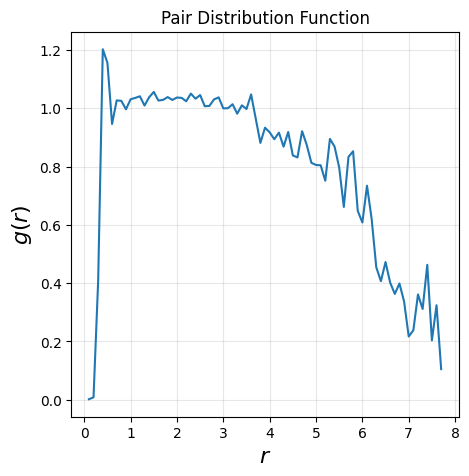

In [5]:
import matplotlib.pyplot as plt

# Plot the function
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(radius_bins, pair_distribution)
ax1.set_title("Pair Distribution Function")
ax1.set_xlabel("$r$", fontsize=16)
ax1.set_ylabel("$g(r)$", fontsize=16)
ax1.grid(True, alpha=0.3)
plt.show()

#### Comments
The function `compute_pair_distibution_function` have two main parameters:
- `radius_bin_size` is the size of the radius bins for which probability will be computed. Larger bin size results in smoother pdf but decrease the accuracy of the description, as more individuals can be detected in each bin. On the other hand, a smaller bin will increase the accuracy of the description but may lead to noisy or `Nan` value as each bean may not be populated (leading to impossible divisions). We suggest using a bin size value between 0.1 and 0.3 m as these values are close to order of magniture of a chest depth.
- `randomisation_stacking` is the number of time the data stacked before being shuffled in order to compute the probability $P_{Ni}$ of measuring given pair-wise distances for pedestrians that do not interact. Stacking multiple times the data allow a better harmonisation of the random position and thus make the pdf converge to result independent of the randomisation method. However, this also increase the computational cost of the pdf and a large number of stacking may not be possible for larger dataset.

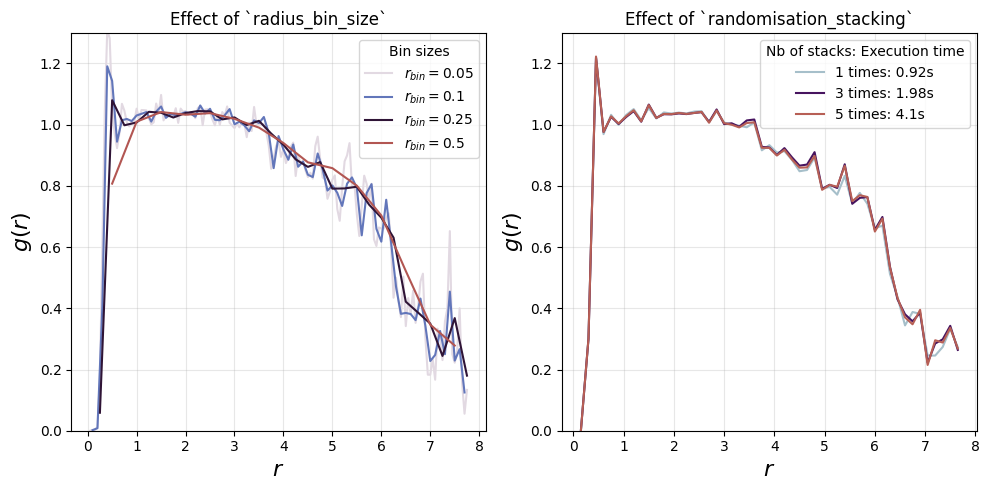

In [21]:
### Variation of the two parameters
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import twilight
from time import time
import pathlib
from pedpy import (
    compute_pair_distibution_function,
    load_trajectory_from_txt,
    TrajectoryUnit,
)

# Load trajectories
path_to_file = "./demo-data/bottleneck/040_c_56_h-.txt"
traj = load_trajectory_from_txt(
    trajectory_file=pathlib.Path(path_to_file),
    default_unit=TrajectoryUnit.METER,
)
# Create a colormap
cmap = twilight


# Plot the function on the first axis
fig, (ax0, ax1) = plt.subplots(
    1, 2, figsize=(10, 5)
)  # create a figure with 2 axes in one row

## Test the effect of `radius_bin_size`
param = [0.05, 0.1, 0.25, 0.5]
N_it = len(param)  # number of plots per parameters

for i, p in enumerate(param):
    # compute the pdf with the given parameter
    radius_bins, pair_distribution = compute_pair_distibution_function(
        traj_data=traj, radius_bin_size=p, randomisation_stacking=1
    )
    ax0.plot(
        radius_bins,
        pair_distribution,
        color=cmap(i / N_it),
        label="$r_{bin}=$" + str(p),
    )

ax0.set_title("Effect of `radius_bin_size`")
ax0.set_ylim((0, 1.3))
ax0.set_xlabel("$r$", fontsize=16)
ax0.set_ylabel("$g(r)$", fontsize=16)
ax0.grid(True, alpha=0.3)
ax0.legend(title="Bin sizes")

## Test the effect of `randomisation_stacking`
param = [1, 3, 5]
N_it = len(param)  # number of plots per parameters

for i, p in enumerate(param):
    beg_t = time()
    radius_bins, pair_distribution = compute_pair_distibution_function(
        traj_data=traj, radius_bin_size=0.15, randomisation_stacking=p
    )
    end_t = time()
    ax1.plot(
        radius_bins,
        pair_distribution,
        color=cmap(0.1 + i / N_it),
        label=str(p) + " times: " + str(np.round(end_t - beg_t, 2)) + "s",
    )


ax1.set_ylim((0, 1.3))
ax1.set_title("Effect of `randomisation_stacking`")
ax1.set_ylabel("$g(r)$", fontsize=16)
ax1.set_xlabel("$r$", fontsize=16)
ax1.grid(True, alpha=0.3)

fig.tight_layout()
ax1.legend(title="Nb of stacks: Execution time")
plt.show()

## Preprocess the data

Until now, we used complete trajectories, but sometimes not all the data is relevant for the analysis. 
If the data comes from larger simulation or experiments you may be only interested in data close to your region of interest or data in a specific time range.
As *PedPy* builds up on *Pandas* as data container, the filtering methods from *Pandas* can also be used here.
More information on filtering and merging with *Pandas* can be found here: [filtering](https://pandas.pydata.org/pandas-docs/version/2.0/user_guide/indexing.html) & [merging](https://pandas.pydata.org/pandas-docs/version/2.0/user_guide/merging.html).

### Geometric filtering

First, we want to filter the data by geometrical principles, therefor we combine the capabilities of *Pandas* and *Shapely*. 

#### Data inside Polygon

In the first case, we are only interested in {class}`trajectory data<trajectory_data.TrajectoryData>` inside the known {class}`measurement area <geometry.MeasurementArea>`. 

In [ ]:
import shapely

bottleneck = shapely.Polygon([(0.25, 0), (0.25, -1), (-0.25, -1), (-0.25, 0)])
leaving_area = shapely.Polygon([(-3, -1), (-3, -2), (3, -2), (3, -1)])

In [ ]:
data_inside_ma = traj.data[shapely.within(traj.data.point, bottleneck)]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

ax = plot_measurement_setup(
    traj=TrajectoryData(data_inside_ma, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(bottleneck)],
    traj_alpha=0.7,
    traj_width=0.4,
    ml_width=1,
    ma_alpha=0.1,
    ma_line_width=1,
)
ax.set_xlim([-0.75, 0.75])
ax.set_ylim([-1.5, 0.5])
ax.set_aspect("equal")
plt.show()

#### Data outside Polygon

Secondly, we want to filter the data, such that the result contains only data which is outside a given area. 
In our case we want to remove all data behind the bottleneck, here called leaving area:

In [ ]:
data_outside_leaving_area = traj.data[
    ~shapely.within(traj.data.point, leaving_area)
]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

ax = plot_measurement_setup(
    traj=TrajectoryData(data_outside_leaving_area, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(leaving_area)],
    traj_alpha=0.7,
    traj_width=0.4,
    ml_width=1,
    ma_alpha=0.1,
    ma_line_width=1,
).set_aspect("equal")

plt.show()

#### Data close to line

It is not only possible to check whether a point is within a given polygon, it is also possible to check if the distance to a given geometrical object is below a given threshold.
Here we want all the data that is within 1m of the {class}`measurement line <geometry.MeasurementLine>` at the entrance of the bottleneck: 

In [ ]:
data_close_ma = traj.data[
    shapely.dwithin(traj.data.point, measurement_line.line, 1)
]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

ax = plot_measurement_setup(
    traj=TrajectoryData(data_close_ma, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_lines=[measurement_line],
    traj_alpha=0.7,
    traj_width=0.4,
    ml_width=1,
    ma_alpha=0.1,
    ma_line_width=1,
)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-2.5, 1.5])
ax.set_aspect("equal")
plt.show()

### Time based filtering

It is not only possible to filter the data by geometrical means, but also depending on time information.
In experiments, you might only be interested in steady state data, this can be also be achieved by slicing the data:

In [ ]:
traj_data_frame_range = traj[300:600]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    traj=traj_data_frame_range,
    walkable_area=walkable_area,
    traj_alpha=0.7,
    traj_width=0.4,
).set_aspect("equal")

plt.show()

Alternatively, you could also utilise the Pandas filtering methods:

In [ ]:
data_frame_range = traj.data[
    traj.data.frame.between(300, 600, inclusive="both")
]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    traj=TrajectoryData(data_frame_range, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_alpha=0.7,
    traj_width=0.4,
).set_aspect("equal")

plt.show()

### ID based filtering

It is also possible to filter the data in a way that only specific pedestrians are contained:

In [ ]:
data_id = traj.data[traj.data.id == 20]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    traj=TrajectoryData(data_id, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_alpha=0.7,
    traj_width=0.4,
).set_aspect("equal")
plt.show()

It is also possible to filter for multiple ids:

In [ ]:
ids = [10, 20, 30, 40]
data_id = traj.data[traj.data.id.isin(ids)]

In [ ]:
from pedpy import plot_measurement_setup
import matplotlib.pyplot as plt

plot_measurement_setup(
    traj=TrajectoryData(data_id, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_alpha=0.7,
    traj_width=0.4,
).set_aspect("equal")

plt.show()

## What to do with the results?

Now we have completed our analysis, what can be done to 

- access specific columns
- combine for further analysis
- save results

### Access specific columns

In order to access a specific column of the computed results or the {class}`trajectory data<trajectory_data.TrajectoryData>` *PedPy* provides all the column names for access.
It is highly encouraged to use these identifiers instead of using the column names directly, as the identifier would be updated, if they change. 
A list of all identifiers can be found in the [API reference](api_column_identifier).

In [ ]:
from pedpy.column_identifier import *

# Access with column identifier
traj.data[[ID_COL, FRAME_COL, POINT_COL]]

In [ ]:
# Access with column names
traj.data[["id", "frame", "point"]]

### Combine multiple DataFrames

From the analysis we have one {class}`~pandas.DataFrame` containing the {class}`trajectory data<trajectory_data.TrajectoryData>`:

In [ ]:
traj.data

and one containing the individual Voronoi data:

In [ ]:
individual

As both have the columns 'id' and 'frame' in common, these can be used to merge the dataframes.
See {func}`pandas.merge` and {meth}`pandas.DataFrame.merge` for more information on how {class}`DataFrames <pandas.DataFrame>` can be merged.

In [ ]:
data_with_voronoi_cells = traj.data.merge(intersecting, on=[ID_COL, FRAME_COL])
data_with_voronoi_cells

In [ ]:
from pedpy.column_identifier import SPEED_COL

data_with_voronoi_cells_speed = data_with_voronoi_cells.merge(
    individual_speed[[ID_COL, FRAME_COL, SPEED_COL]], on=[ID_COL, FRAME_COL]
)
data_with_voronoi_cells_speed

### Save in files

For preserving the results on the disk, the results need to be saved on the disk.
This can be done with the build-in functions from *Pandas*.

#### Create directories to store the results

First we create a directory, where we want to save the results.
This step is optional!

In [ ]:
pathlib.Path("results_introduction/profiles/speed").mkdir(
    parents=True, exist_ok=True
)
pathlib.Path("results_introduction/profiles/density").mkdir(
    parents=True, exist_ok=True
)

results_directory = pathlib.Path("results_introduction")

#### Save Pandas DataFrame (result from everything but profiles) as csv

Now, a {class}`~pandas.DataFrame` can be saved as `csv` with:

In [ ]:
from pedpy.column_identifier import (
    X_COL,
    Y_COL,
    DENSITY_COL,
    INTERSECTION_COL,
    POLYGON_COL,
)
import csv

with open(
    results_directory / "individual_result.csv", "w"
) as individual_output_file:
    individual_output_file.write(f"#framerate:	{traj.frame_rate}\n\n")
    data_with_voronoi_cells_speed[
        [
            ID_COL,
            FRAME_COL,
            X_COL,
            Y_COL,
            DENSITY_COL,
            SPEED_COL,
            POLYGON_COL,
            INTERSECTION_COL,
        ]
    ].to_csv(
        individual_output_file,
        mode="a",
        header=True,
        sep="\t",
        index_label=False,
        index=False,
        quoting=csv.QUOTE_NONNUMERIC,
    )

#### Save numpy arrays (result from profiles) as txt

The profiles are returned as Numpy arrays, which also provide a build-in save function, which allows to save the arrays as txt format:

In [ ]:
results_directory_density = results_directory / "profiles/density"
results_directory_speed = results_directory / "profiles/speed"

for i in range(len(range(min_frame_profiles, min_frame_profiles + 10))):
    frame = min_frame_profiles + i
    np.savetxt(
        results_directory_density / f"density_frame_{frame:05d}.txt",
        density_profiles[i],
    )
    np.savetxt(
        results_directory_speed / f"speed_frame_{frame:05d}.txt",
        speed_profiles[i],
    )